# Get the Data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


- Splitting into data and labels

In [3]:
X, y = mnist.data, mnist.target
X 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

- 70000 instances with 784 features (784 features being individual pixels in a 28x28 image, each pixel stores a grey scale value of 0 - 255)

### Visualising the Data

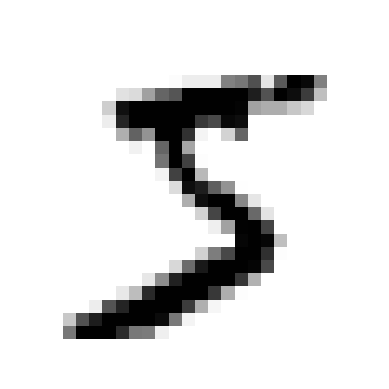

In [5]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image=image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [6]:
y[0]

'5'

- The label for the digit shown above

- Creating a test set and training set. This particular dataset already has been split into test and training data and labels
- Additionally, the test and training data has been shuffled based on stratified data so this can be done. Usually, ev

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

- Making the below true if the label is 5

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

- Training a Stochastic Gradient Descent Classifier

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit]) #Shows that the some_digit object was predicted true (i.e it is a 5)

array([ True])

# Measuring Performance

### Accuracy with Cross Validation

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") #Seems high but if we compare it to a DummyClassifier we can see the problem

array([0.95035, 0.96035, 0.9604 ])

In [12]:
#Dummy classifier is trained on the negative cases (i.e all numbers that arent a 5)
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(f"There are 5's in this dummy prediction: {any(dummy_clf.predict(X_train))}")

There are 5's in this dummy prediction: False


In [13]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

- High accuracy as the probability of guessing a 5 is only approximately 1 in 10, so the probability of not guessing a 5 is 9 in 10. Does not mean anything significant with regards to accuracy
- Accuracy is not a good way to measure performance in this case
- Accuracy is the ratio of correctly detected labels

In [14]:
#Side Note: Implementing CrossValidation from scratch with Stratified Sampling

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def StratifiedCV(estimator, X, y, cv=1):
    skfolds = StratifiedKFold(n_splits=cv)
    stratcv = []

    for train_index, test_index in skfolds.split(X, y):
        clone_clf = clone(estimator) #Cloning the 
        X_train_folds = X[train_index]
        y_train_folds = y[train_index]
        X_test_fold = X[test_index]
        y_test_fold = y[test_index]

        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        stratcv.append(n_correct/len(y_pred))
    
    return stratcv

In [15]:
StratifiedCV(sgd_clf, X_train, y_train_5, cv=3)

[0.95035, 0.96035, 0.9604]

# Confusion Matrix

- Consists of True negatves, false positives, false negatives, true positives

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) #Returns the predictions, not the scores


In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred) #Creates the confusion matrix
cm

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
print(f"True Negatives: {cm[0][0]}, False Positives: {cm[0][1]}, False Negatives: {cm[1][0]}, True Positives: {cm[1][1]} ") #Reference for me for where everything is

True Negatives: 53892, False Positives: 687, False Negatives: 1891, True Positives: 3530 


In [19]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions) #For more reference

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

- Precision is the accuracy of the predictions (Meaning a ratio of the true positives by the total predictions for positives)
- Recall is used with precision and is sometimes called trhe sensitivity and the positive rate (A ratio of the the true positives to the total number of 5)

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- Precision and recall can be combined into a harmonic mean called the F1 Score
- High F1 score only if both recall and precision are high, if not, then it is much lower

In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade off

- Setting a threshold for the decision function for the SGD classifier manually, raising theshold decreases recall

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") #Returns the decision scores so that it can be used for the trhreshold
y_scores 

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) #COmputes precision and recall for all threshold values

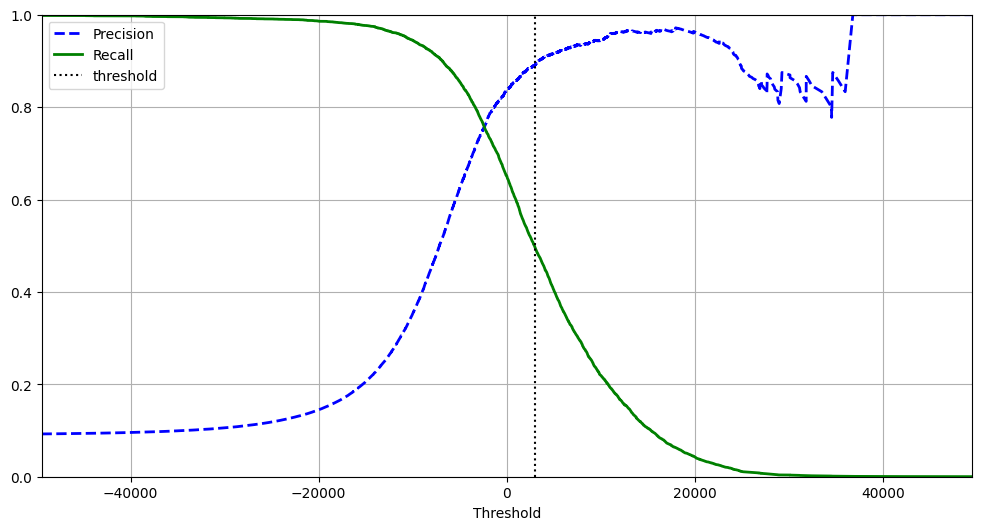

In [25]:
threshold = 3000


plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k","dotted", label="threshold")
plt.grid()
plt.xlim([-max(thresholds), max(thresholds)])
plt.ylim([0., 1.])
plt.xlabel("Threshold")
plt.legend()
plt.show()

- Bumpy due to threshold changing and possibly including more true positives or false negatives 

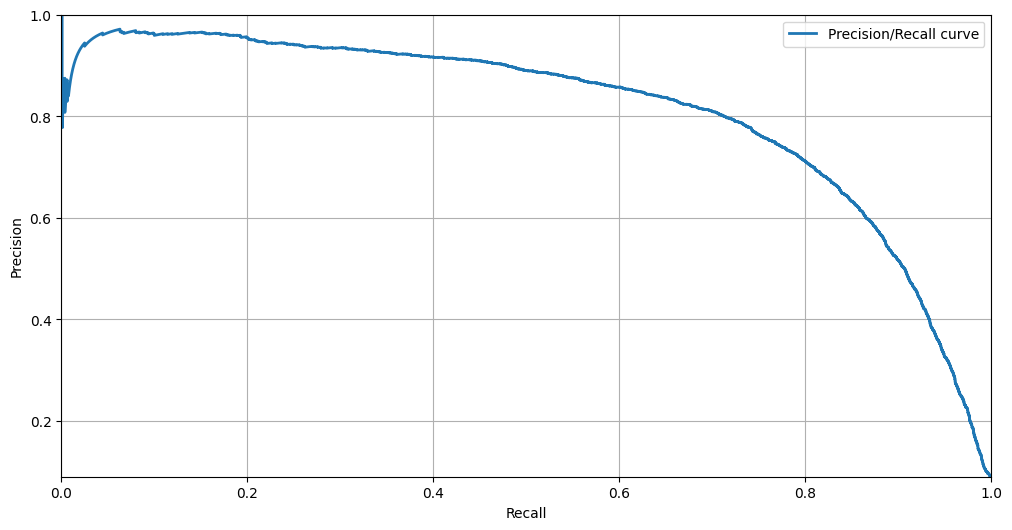

In [26]:
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.grid()
plt.legend()
plt.xlim([min(recalls), max(recalls)])
plt.ylim([min(precisions), max(precisions)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

- Creating a classifier with a specified precision score

In [27]:
idx_for_90_precision = (precisions >= 0.90).argmax() #Get the index for the precision score that is greater than or equal to 90 and get the first index
threshold_for_90_precision = thresholds[idx_for_90_precision] # Gets the threshold value for the precision 

In [28]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90) #Checking

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90) #Recall score at 90% precision

0.4799852425751706

- Good precision but practically, the recall score is too low

### The ROC Curve

- Recall vs the false positive rate

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

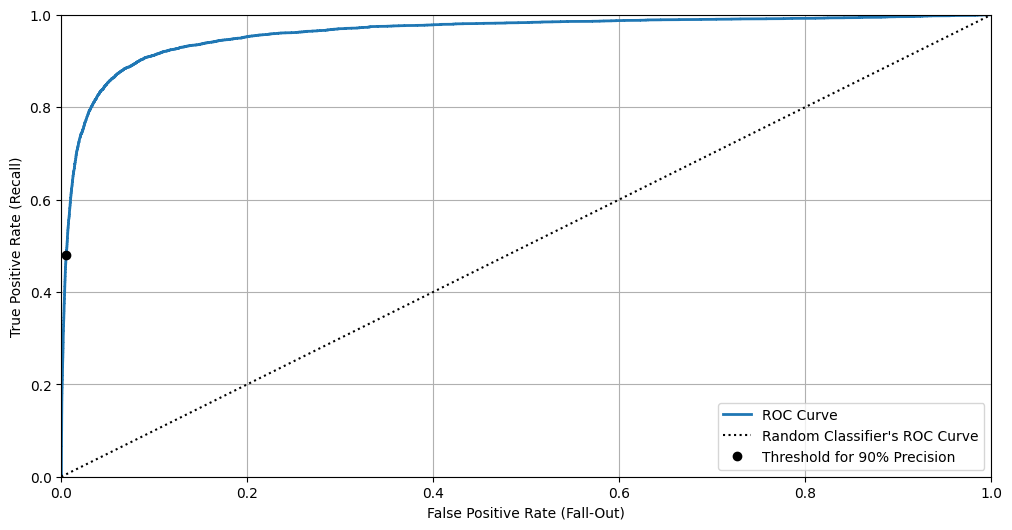

In [31]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax() #Gets the threshodls which are below the threshold when achieing a 90% precision, and gets the first instance of this
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.rcParams["figure.figsize"] = (12,6)
plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0,1], [0,1], 'k:', label="Random Classifier's ROC Curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% Precision")
plt.xlim([min(fpr), max(fpr)])
plt.ylim([min(tpr), max(tpr)])
plt.grid()
plt.legend()
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

- The higher the recall, the more false positive rates exist (Makes sense, if you recall more while having a lower precision, there will be less true positives)

In [32]:
#ROC AUC (Approaches approximately 1)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores) 

0.9604938554008616

- Creating a random forest classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [34]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [35]:
y_probas_forest[:2] #Just gets the first two

array([[0.11, 0.89],
       [0.98, 0.02]])

In [36]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)

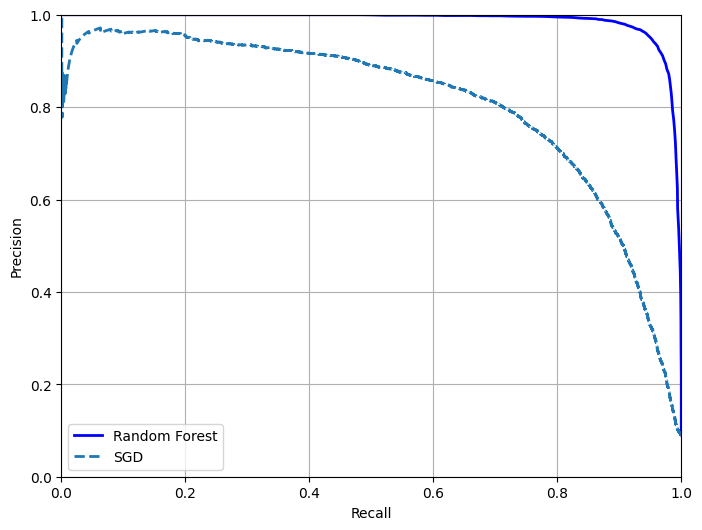

In [37]:
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend()
plt.show()

- Random forest tree much closer to an area underneath of 1, must see however

In [38]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 
f1_score(y_train_5, y_train_pred_forest)

0.9270445185330457

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983296721818179

### Multiclass Classification

- Using the Support Vector Machine Classifier is only binary, but if required to use for multiclass, it will automatically switch to using one v one strategy

In [40]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [41]:
svm_clf.predict([some_digit]) #Correct

array(['5'], dtype=object)

In [42]:
some_digit_scores = svm_clf.decision_function([some_digit]) #Decision function will show why the ml model made the decision, (i.e the one for 5 had a better score)
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [43]:
class_id = some_digit_scores.argmax()
class_id

5

In [44]:
svm_clf.classes_[class_id]

'5'

In [45]:
from sklearn.multiclass import OneVsRestClassifier #One vs Rest strategy

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [46]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [47]:
len(ovr_clf.estimators_) #The number of trained classifiers

10

- Training Stochastic Gradient descent classifier for multiclass, not binary

In [48]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [49]:
sgd_clf.predict([some_digit]) #Wrong

array(['3'], dtype='<U1')

In [50]:
sgd_clf.decision_function([some_digit]).round(2) #Low confidence

array([[-31893.03, -34419.69,  -9530.64,   1823.73, -22320.15,  -1385.8 ,
        -26188.91, -16147.51,  -4604.35, -12050.77]])

In [51]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

- Helps in selecting a model for hyperparamter tuning
- Confusion matrix for multiclass classification is a bit different

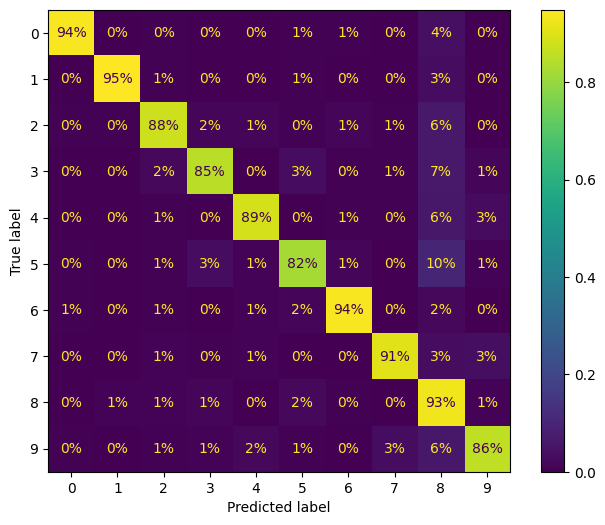

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show() #3s predicted true the least

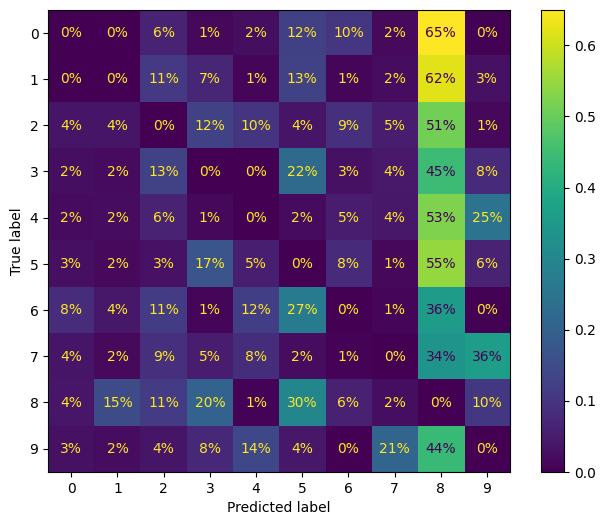

In [54]:
sample_weight = (y_train_pred != y_train) #Shows the errors (where the predictions are not equal to the training data)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.show() #8s are easily mistaken for other numbers

### Multilabel Classification

In [55]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

#Making a kNN multilabel classifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [56]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
knn_clf.predict([some_digit]) #False that the number is lager than 7 and True that it is an odd number

array([[False,  True]])

In [58]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [59]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted") #Weighted based on the stratified statistics

0.9778357403921755

- Makiong chain classifier if you want to use a model that doesnt support multilabel classification such as svc, a chain of models trained on each label
- Chain classifier can be used

In [60]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [61]:
chain_clf.predict([some_digit])

array([[0., 1.]])

### Multioutput Classification

- Where the label can have more than two classes

In [63]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [64]:
y_train_mod = X_train
y_test_mod = X_test

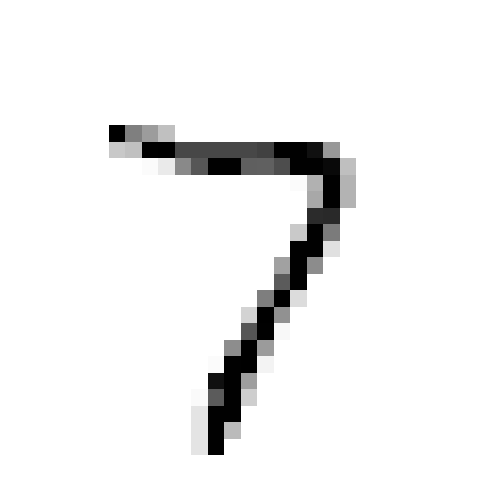

In [67]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

### Excercises

1. Build Classifier with MNIST dataset that achieves 97% accuracy on a test set

In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
initial_accuracy = knn_clf.score(X_test, y_test)
initial_accuracy

0.9688

In [102]:
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'weights': ['uniform','distance']}

grid_search = GridSearchCV(knn_clf, param_grid=param_grid, cv=3)

In [103]:
grid_search.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'weights': ['uniform', 'distance']})

In [104]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [105]:
grid_search.best_estimator_.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [106]:
new_accuracy = grid_search.score(X_test, y_test)

In [107]:
new_accuracy

0.9714

2. Data Augmentation 
- Make it so so that each label has 5 instances of it, where the same image has 4 other variants, shifted one pixel up down, left and right

In [108]:
y_train #Labels

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

In [143]:
from scipy.ndimage import shift

def shifted(X, dx, dy):
    shifted_X = shift(X.reshape((28,28)), [dx, dy], mode='constant', cval=0)
    return shifted_X.reshape([-1])

In [144]:
digit_shifted = shifted(X_train[10], -1, 1)

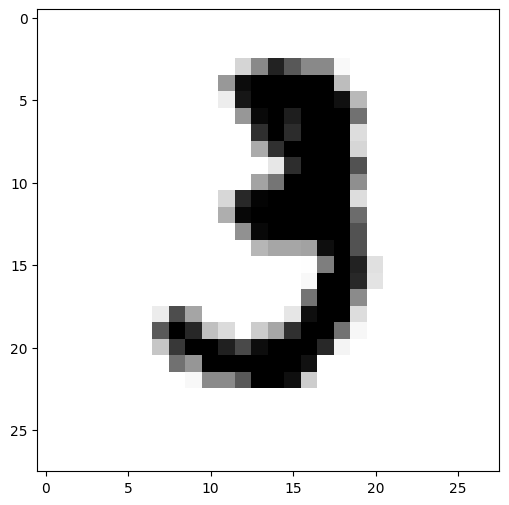

In [145]:
plt.imshow(digit_shifted.reshape(28, 28), cmap="binary", interpolation="nearest")

In [157]:
X_train_augmented = [X for X in X_train]
y_train_augmented = [y for y in y_train]

for i in range(len(X_train)):
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if abs(dx) != abs(dy):
                X_train_augmented.append(shifted(X_train[i], dx, dy))
                y_train_augmented.append(y_train[i])

In [159]:
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

idx_shuffle = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[idx_shuffle]
y_train_augmented = y_train_augmented[idx_shuffle]

In [160]:
#Train on the previous best grid search

grid_search.best_estimator_.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [161]:
augmented_accuracy = grid_search.score(X_test, y_test)

In [162]:
augmented_accuracy #Improved accuracy

0.9763